In [1]:
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader,TensorDataset
from gensim.models import Word2Vec

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class RNNcVAE(nn.Module):
    def __init__(self, embedding_matrix, idx2word, num_classes, hidden_dim, latent_dim, num_layers, sos_token, vocab_size):
        super(RNNcVAE, self).__init__()

        self.embedding_dim = embedding_matrix.shape[1]
        self.idx2word = idx2word
        self.sos_token = sos_token
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True)
        self.layer_norm = nn.LayerNorm(self.embedding_dim)

        self.encoder = nn.RNN(self.embedding_dim, hidden_dim, num_layers, batch_first = True)
        self.decoder = nn.RNN(self.embedding_dim, hidden_dim, num_layers, batch_first = True)

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)  
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_hidden = nn.Linear(latent_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, vocab_size)

        self.fc_condition = nn.Linear(num_classes, latent_dim)

    
    def forward(self, x, label):
        embedded_input = self.embedding(x)
        embedded_input = self.layer_norm(embedded_input)

        _, hn = self.encoder(embedded_input)

        mu = self.fc_mu(hn)
        logvar = self.fc_logvar(hn)
        z = self.reparametrization(mu, logvar)

        z = self.condition_on_label(z, label)
        z = self.fc_hidden(z)

        # prepare sos_token for the decoder
        sos_token = self.sos_token.repeat(x.size(0),1)
        sos_token = self.embedding(sos_token)
        sos_token = self.layer_norm(sos_token)

        decoder_input = torch.cat((sos_token, embedded_input), dim = 1)
        decoder_input = decoder_input[:,:-1,:]

        reconstructed_sequence, _ = self.decoder(decoder_input, z)
        '''# reconstructing sequence through the decoder giving z as hidden state for each time step
        reconstructed_sequence = []
        for t in range(x.shape[1]):
            outputs, _ = self.decoder(decoder_input[:,:t+1,:], z)
            reconstructed_sequence.append(outputs[:,-1,:].unsqueeze(1))

        # concatenating reconstructed words and push them into vocab_size dimensions
        reconstructed_sequence = torch.cat(reconstructed_sequence, dim=1)'''
        reconstructed_sequence = self.fc(reconstructed_sequence)
        
        return reconstructed_sequence, mu, logvar
    


    def reparametrization(self, mu, log_var):
        ''' Reparametrization trick
        
        Inputs
        -------
        mu : torch tensor
        log_var : torch tensor
            
        
        Returns
        -------
        mu + eps*std : torch tensor with the same shape as mu and log_var'''
        
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)

        return mu + eps*std



    def condition_on_label(self, z, label):
        projected_label = self.fc_condition(label)
        projected_label = projected_label.repeat((self.num_layers,1,1))

        return z + projected_label


    def reconstruction(self, x, label, sample_type = 'multinomial'):
        ''' Reconstruction function for inference
        Input
        -------
        x : torch tensor with shape [Batch_size, Sequence_length], input sequence
            
        
        Returns
        -------
        outputs : torch tensor with shape [Batch_size, Sequence_length, Embedding_dim], the reconstructed sentence'''
        self.eval()
        with torch.no_grad():

            # embedding input and GRU encoder pass
            embedded_input = self.embedding(x)
            embedded_input = self.layer_norm(embedded_input)
            _, hn = self.encoder(embedded_input)
            
            # computing mu and log_var for style and content space
            mu_s = self.fc_mu(hn)
            logvar_s = self.fc_logvar(hn)

            # reparametrization for style and content
            z = self.reparametrization(mu_s, logvar_s)
            z = self.condition_on_label(z, label)

            # concatenating style and content space
            z = self.fc_hidden(z)

            # prepare sos_token for the decoder
            sos_token = self.sos_token.repeat(x.size(0),1)
            sos_token = self.embedding(sos_token)
            sos_token = self.layer_norm(sos_token)


            # decoder pass where the input is the previous output
            output = sos_token
            for _ in range(x.shape[1]):
                outputs, _ = self.decoder(output, z)
                outputs = self.fc(outputs)
                next_token = torch.argmax(F.softmax(outputs[:,-1,:], dim = -1), dim=-1)
                #next_token = torch.multinomial(F.softmax(outputs[:,-1,:], dim = -1), 1)
                next_token = self.embedding(next_token)
                next_token = self.layer_norm(next_token)
                output = torch.cat((output, next_token.unsqueeze(1)), dim=1)
                #output = torch.cat((output, next_token), dim=1)
        
            
            
        if sample_type == 'argmax':
            output = torch.argmax(F.softmax(outputs.mean(0), dim = -1), dim = -1)
            
        elif sample_type == 'multinomial':
            output = torch.multinomial(F.softmax(outputs.mean(0), dim = -1), 1)
            

        reconstructed_text = [self.idx2word[w.item()] for w in output]

        return ' '.join(reconstructed_text)
    

    def sample(self, label, len_sample = 25, temperature = 1, sample_type = 'multinomial'):
        z = torch.randn((self.num_layers, 1, self.latent_dim))

        self.eval()
        with torch.no_grad():
            z = self.condition_on_label(z, label)
            z = self.fc_hidden(z)

            # prepare sos_token for the decoder
            sos_token = self.sos_token.repeat(1,1)
            sos_token = self.embedding(sos_token)
            sos_token = self.layer_norm(sos_token)



            sampled_text = []
            # decoder pass where the input is the previous output
            output = sos_token
            for _ in range(len_sample):
                outputs, _ = self.decoder(output, z)
                outputs = self.fc(outputs)
                #next_token = torch.argmax(F.softmax(outputs[:,-1,:] / temperature, dim = -1), dim=-1)
                next_token = torch.multinomial(F.softmax(outputs[:,-1,:] / temperature, dim = -1), 1)
                sampled_text.append(next_token)
                next_token = self.embedding(next_token)
                next_token = self.layer_norm(next_token)
                #output = torch.cat((output, next_token.unsqueeze(1)), dim=1)
                output = torch.cat((output, next_token), dim=1)
       

        if sample_type == 'argmax':
            output = torch.argmax(F.softmax(outputs.mean(0), dim = -1), dim = -1)

        elif sample_type == 'multinomial':
            output = torch.multinomial(F.softmax(outputs.mean(0), dim = -1), 1)
        
        

        #sampled_text = [self.idx2word[w.item()] for w in output]
        sampled_text = [self.idx2word[w.item()] for w in sampled_text]

        return ' '.join(sampled_text)
    

    

    def number_parameters(self):

        model_params = sum(p.numel() for p in self.parameters() if p.requires_grad)

        print('Total number of model parameters: ', model_params)

        return None

In [4]:
class GRUcVAE(RNNcVAE, nn.Module):
    def __init__(self, embedding_matrix, idx2word, num_classes, hidden_dim, latent_dim, num_layers, sos_token, vocab_size):
        super(GRUcVAE, self).__init__(embedding_matrix, idx2word, num_classes, hidden_dim, latent_dim, num_layers, sos_token, vocab_size)

        self.embedding_dim = embedding_matrix.shape[1]
        self.idx2word = idx2word
        self.sos_token = sos_token
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True)
        self.layer_norm = nn.LayerNorm(self.embedding_dim)

        self.encoder = nn.GRU(self.embedding_dim, hidden_dim, num_layers, batch_first = True)
        self.decoder = nn.GRU(self.embedding_dim, hidden_dim, num_layers, batch_first = True)

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)  
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_hidden = nn.Linear(latent_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, vocab_size)

In [5]:
class LSTMcVAE(nn.Module):
    def __init__(self, embedding_matrix, idx2word, num_classes, hidden_dim, latent_dim, num_layers, sos_token, vocab_size):
        super(LSTMcVAE, self).__init__()

        self.embedding_dim = embedding_matrix.shape[1]
        self.idx2word = idx2word
        self.sos_token = sos_token
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True)
        self.layer_norm = nn.LayerNorm(self.embedding_dim)

        self.encoder = nn.LSTM(self.embedding_dim, hidden_dim, num_layers, batch_first = True)
        self.decoder = nn.GRU(self.embedding_dim, hidden_dim, num_layers, batch_first = True)

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)  
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_hidden = nn.Linear(latent_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, vocab_size)

        self.fc_condition = nn.Linear(num_classes, latent_dim)

    
    def forward(self, x, label):
        embedded_input = self.embedding(x)
        embedded_input = self.layer_norm(embedded_input)

        _, (hn, cn) = self.encoder(embedded_input)

        mu = self.fc_mu(hn)
        logvar = self.fc_logvar(hn)
        z = self.reparametrization(mu, logvar)

        z = self.condition_on_label(z, label)
        z = self.fc_hidden(z)

        # prepare sos_token for the decoder
        sos_token = self.sos_token.repeat(x.size(0),1)
        sos_token = self.embedding(sos_token)
        sos_token = self.layer_norm(sos_token)

        decoder_input = torch.cat((sos_token, embedded_input), dim = 1)
        decoder_input = decoder_input[:,:-1,:]

        reconstructed_sequence, _ = self.decoder(decoder_input, z)
        '''# reconstructing sequence through the decoder giving z as hidden state for each time step
        reconstructed_sequence = []
        for t in range(x.shape[1]):
            outputs, _ = self.decoder(decoder_input[:,:t+1,:], z)
            reconstructed_sequence.append(outputs[:,-1,:].unsqueeze(1))

        # concatenating reconstructed words and push them into vocab_size dimensions
        reconstructed_sequence = torch.cat(reconstructed_sequence, dim=1)'''
        reconstructed_sequence = self.fc(reconstructed_sequence)
        
        return reconstructed_sequence, mu, logvar
    


    def reparametrization(self, mu, log_var):
        ''' Reparametrization trick
        
        Inputs
        -------
        mu : torch tensor
        log_var : torch tensor
            
        
        Returns
        -------
        mu + eps*std : torch tensor with the same shape as mu and log_var'''
        
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)

        return mu + eps*std



    def condition_on_label(self, z, label):
        projected_label = self.fc_condition(label)
        projected_label = projected_label.repeat((self.num_layers,1,1))

        return z + projected_label


    def reconstruction(self, x, label, sample_type = 'multinomial'):
        ''' Reconstruction function for inference
        Input
        -------
        x : torch tensor with shape [Batch_size, Sequence_length], input sequence
            
        
        Returns
        -------
        outputs : torch tensor with shape [Batch_size, Sequence_length, Embedding_dim], the reconstructed sentence'''
        self.eval()
        with torch.no_grad():

            # embedding input and GRU encoder pass
            embedded_input = self.embedding(x)
            embedded_input = self.layer_norm(embedded_input)
            _, (hn, cn) = self.encoder(embedded_input)
            
            # computing mu and log_var for style and content space
            mu_s = self.fc_mu(hn)
            logvar_s = self.fc_logvar(hn)

            # reparametrization for style and content
            z = self.reparametrization(mu_s, logvar_s)
            z = self.condition_on_label(z, label)

            # concatenating style and content space
            z = self.fc_hidden(z)

            # prepare sos_token for the decoder
            sos_token = self.sos_token.repeat(x.size(0),1)
            sos_token = self.embedding(sos_token)
            sos_token = self.layer_norm(sos_token)


            # decoder pass where the input is the previous output
            output = sos_token
            for _ in range(x.shape[1]):
                outputs, _ = self.decoder(output, z)
                outputs = self.fc(outputs)
                next_token = torch.argmax(F.softmax(outputs[:,-1,:], dim = -1), dim=-1)
                #next_token = torch.multinomial(F.softmax(outputs[:,-1,:], dim = -1), 1)
                next_token = self.embedding(next_token)
                next_token = self.layer_norm(next_token)
                output = torch.cat((output, next_token.unsqueeze(1)), dim=1)
                #output = torch.cat((output, next_token), dim=1)
        
            
            
        if sample_type == 'argmax':
            output = torch.argmax(F.softmax(outputs.mean(0), dim = -1), dim = -1)
            
        elif sample_type == 'multinomial':
            output = torch.multinomial(F.softmax(outputs.mean(0), dim = -1), 1)
            

        reconstructed_text = [self.idx2word[w.item()] for w in output]

        return ' '.join(reconstructed_text)
    

    def sample(self, label, len_sample = 25, temperature = 1, sample_type = 'multinomial'):
        z = torch.randn((self.num_layers, 1, self.latent_dim))

        self.eval()
        with torch.no_grad():
            z = self.condition_on_label(z, label)
            z = self.fc_hidden(z)

            # prepare sos_token for the decoder
            sos_token = self.sos_token.repeat(1,1)
            sos_token = self.embedding(sos_token)
            sos_token = self.layer_norm(sos_token)



            sampled_text = []
            # decoder pass where the input is the previous output
            output = sos_token
            for _ in range(len_sample):
                outputs, _ = self.decoder(output, z)
                outputs = self.fc(outputs)
                #next_token = torch.argmax(F.softmax(outputs[:,-1,:] / temperature, dim = -1), dim=-1)
                next_token = torch.multinomial(F.softmax(outputs[:,-1,:] / temperature, dim = -1), 1)
                sampled_text.append(next_token)
                next_token = self.embedding(next_token)
                next_token = self.layer_norm(next_token)
                #output = torch.cat((output, next_token.unsqueeze(1)), dim=1)
                output = torch.cat((output, next_token), dim=1)
       

        if sample_type == 'argmax':
            output = torch.argmax(F.softmax(outputs.mean(0), dim = -1), dim = -1)

        elif sample_type == 'multinomial':
            output = torch.multinomial(F.softmax(outputs.mean(0), dim = -1), 1)
        
        

        #sampled_text = [self.idx2word[w.item()] for w in output]
        sampled_text = [self.idx2word[w.item()] for w in sampled_text]

        return ' '.join(sampled_text)
    

    

    def number_parameters(self):

        model_params = sum(p.numel() for p in self.parameters() if p.requires_grad)

        print('Total number of model parameters: ', model_params)

        return None

In [6]:
def divide_text(text, sequence_length):
    ''' Function dividing text in order to feed the Word2vec model
    
    Inputs
    ----------
    text : text corpus from a file
    sequence_length : int
    
    
    Returns
    ----------
    output_text : 2D list of words with shape [text_length/sequence_length, sequence_length]'''

    words = text.split()
    grouped_words = [' '.join(words[i:i+sequence_length]) for i in range(0,len(words),int(sequence_length/2))]  
    output_text = [grouped_words[i].split() for i in range(len(grouped_words))]

    return output_text

In [7]:
def divide_text_equal_seq_length(text, sequence_length):
    ''' Function dividing text in order to feed the Word2vec model
    
    Inputs
    ----------
    text : text corpus from a file
    sequence_length : int
    
    
    Returns
    ----------
    output_text : 2D list of words with shape [text_length/sequence_length, sequence_length]'''

    words = text.split()
    grouped_words = [' '.join(words[i:i+sequence_length]) for i in range(0,len(words),int(sequence_length/6))]  
    output_text = [grouped_words[i].split() for i in range(len(grouped_words)) if len(grouped_words[i].split()) == sequence_length]

    return output_text

In [8]:
def custom_dataset(file1 : str, file2 : str, file3 : str, sequence_length, embedding_dim, batch_size, training_fraction):
    ''' Function creating dataset
    
    Inputs
    ----------
    file1 : str, name of the file containing the first corpus
    file2 : str, name of the file containing the second corpus
    file3 : str, name of the file containing the third corpus
    sequence_length : int
    embedding_dim : int, number of dimension for the embedded words using Word2vec model
    batch_size : int
    training_fraction : float, fraction of training data
    
    
    Returns
    ----------
    dataloader_train : istance of torch.utils.data.Dataloader, training data
    dataloader_val : istance of torch.utils.data.Dataloader, validation data
    embedding_dim : int
    embedding_matrix : 2d torch tensor matrix from word2vec embedding
    word2vec : trained Word2vec model
    idx2word : dictionary from indices to words
    word2idx : dictionart from words to indices
    vocab_size : int, number of unique tokens
    style0_test : torch tensor containing every test data belonging to first style
    style1_test : torch tensor containing every test data belonging to second style
    style3_test : torch tensor containing every test data belonging to third style'''

    # reading the two corpus
    with open(file1, 'r', encoding='utf-8') as f:
        text1 = f.read()


    with open(file2, 'r', encoding='utf-8') as f:
        text2 = f.read()

    with open(file3, 'r', encoding='utf-8') as f:
        text3 = f.read()
    

    # adding a special token for the start of the sequence
    text1 = '<sos> ' + text1 
    text = text1 + ' ' + text2 + ' ' + text3

    # divide the whole text to feed the Word2vec model
    divided_text = divide_text(text, sequence_length)

    # training the Word2vec model with the whole corpus
    word2vec = Word2Vec(divided_text, vector_size = embedding_dim, window = sequence_length, min_count=1, workers=4, epochs = 30)
    word2vec.train(divided_text, total_examples=word2vec.corpus_count, epochs=word2vec.epochs)

    # Get the embedding dimension
    embedding_dim = word2vec.wv.vector_size

    # Prepare the embedding matrix
    vocab_size = len(word2vec.wv)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    word2idx = {word: idx for idx, word in enumerate(word2vec.wv.index_to_key)}
    idx2word = {idx: word for idx, word in enumerate(word2vec.wv.index_to_key)}

    # creating the embedding matrix from the trained Word2vec model
    for word, idx in word2idx.items():
        embedding_matrix[idx] = word2vec.wv[word]

    
    embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)


    # dividing only the first text
    text1_divided = divide_text_equal_seq_length(text1, sequence_length)
    data1 = torch.LongTensor([[word2idx[char] for char in text1_divided[i]] for i in range(len(text1_divided))])

    
    # dividing only the second text
    text2_divided = divide_text_equal_seq_length(text2, sequence_length)
    data2 = torch.LongTensor([[word2idx[char] for char in text2_divided[i]] for i in range(len(text2_divided))])


    text3_divided = divide_text_equal_seq_length(text3, sequence_length)
    data3 = torch.LongTensor([[word2idx[char] for char in text3_divided[i]] for i in range(len(text3_divided))])


    # defining training and validation data for the first style
    data1_train = data1[:int(training_fraction * data1.shape[0])]
    data1_val = data1[int(training_fraction * data1.shape[0]): ]
    

    # defining training and validation data for the second style
    data2_train = data2[:int(training_fraction * data2.shape[0])]
    data2_val = data2[int(training_fraction * data2.shape[0]): ]
    


    data3_train = data3[:int(training_fraction * data3.shape[0])]
    data3_val = data3[int(training_fraction * data3.shape[0]): ]
    

    # creating training and validation labels for the first style
    label0_train = torch.tensor([1,0,0]).repeat((data1_train.shape[0],1))
    label0_val = torch.tensor([1,0,0]).repeat((data1_val.shape[0],1))


    # creating training and validation labels for the second style
    label1_train = torch.tensor([0,1,0]).repeat((data2_train.shape[0],1))
    label1_val = torch.tensor([0,1,0]).repeat((data2_val.shape[0],1))


    label2_train = torch.tensor([0,0,1]).repeat((data3_train.shape[0],1))
    label2_val = torch.tensor([0,0,1]).repeat((data3_val.shape[0],1))


    # creating training and validation labels
    labels_train = torch.cat((label0_train, label1_train, label2_train), dim = 0)
    labels_val = torch.cat((label0_val, label1_val, label2_val), dim = 0)

    # creating training and validation data
    data_train = torch.cat((data1_train, data2_train, data3_train), dim = 0)
    data_val = torch.cat((data1_val, data2_val, data3_val), dim = 0)

    data_train = torch.LongTensor(data_train)
    labels_train = labels_train.type(torch.LongTensor)

    dataset_train = TensorDataset(data_train, labels_train)

    # Create a training DataLoader with shuffling enabled
    dataloader_train = DataLoader(dataset_train, batch_size = batch_size, shuffle=True)
   


    data_val = torch.LongTensor(data_val)
    labels_val = labels_val.type(torch.LongTensor)

    dataset_val = TensorDataset(data_val, labels_val)

    # Create a validation DataLoader with shuffling enabled
    dataloader_val = DataLoader(dataset_val, batch_size = batch_size, shuffle = True)
    
    
    return dataloader_train, dataloader_val, embedding_dim, embedding_matrix, word2vec, idx2word, word2idx, vocab_size

In [9]:
def vae_loss(recon_x, x, mu, logvar, l_kl = 0.05, loss_fn = nn.CrossEntropyLoss()):
    ''' Function computing loss function for classification
    
    Inputs
    ---------
    pred_labels : 3D torch tensor with predicted labels with shape [1, Batch size, 3]
    labels : 2D torch tensor with ground truth labels with shape [Batch size, 3]
    
    Returns
    ---------
    L : float, loss value '''

    L = loss_fn(recon_x.reshape((recon_x.size(0)*recon_x.size(1),recon_x.size(2))), x.view(-1))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return L + l_kl * KLD

# Sigmoid controlling l_kl:
* k = 0.183, t0 = 20
* k = 0.11, t0 = 30


k = - ln(32.33333)/(1-t0)

In [10]:
def sigmoid(x, k = 0.183, t0 = 20):
    
    return 1/(1 + np.exp(-k*(x-t0)))

In [11]:
def training(model, train_loader, val_loader, num_epochs, lr = 4e-4, title = 'Training'):
    ''' Training function
    
    Input
    --------
    model : istance of a CNNClassifier, RNNClassifier, GRUClassifier, LSTMClassifier or TClassifier
    train_loader : istance of torch Dataloader with training data and labels
    val_loader : istance of torch Dataloader with validation data and labels
    num_epochs : int, number of epochs
    lr : float, learning rate for Adam optimizer
    title : str, Title of the matplot figure
    
    Returns
    --------
    train_losses : list with train loss values '''

    params = list(model.parameters())

    # Optimizer
    optimizer = torch.optim.Adam(params, lr = lr)

    
    train_losses = []
    val_losses = []
    

    l_kl = 0.05

    # For loop over epochs
    for epoch in tqdm(range(num_epochs)):
        #l_kl = sigmoid(epoch + 1)
        train_loss = 0.0
        average_loss = 0.0
        val_loss = 0.0
        average_val_loss = 0.0


        # For loop for every batch
        for  i, (inputs, label) in enumerate(train_loader):
            inputs = inputs.to(device)
            label = label.to(device)
            label = label.type(torch.FloatTensor)

            optimizer.zero_grad()
            

            # forward pass through classifier
            recon_x, mu, logvar = model(inputs, label)
    
            # comuting training loss
            loss = vae_loss(recon_x.to(device),
                            inputs.to(device),
                            mu.to(device),
                            logvar.to(device),
                            l_kl)
            
            loss.backward()
            train_loss += loss.item()


            optimizer.step()

            
            
        
        
        # Validation
        with torch.no_grad():
            for i, (inputs, label) in enumerate(val_loader):
                inputs = inputs.to(device)
                label = label.to(device)
                label = label.type(torch.FloatTensor)
    

                # forward pass through classifier
                recon_x, mu, logvar = model(inputs, label)
                
                
                # comuting validation loss
                val_loss_tot = vae_loss(recon_x.to(device),
                                        inputs.to(device),
                                        mu.to(device),
                                        logvar.to(device),
                                        l_kl)
                
                val_loss += val_loss_tot.item()



            
        
        # Computing average training and validation loss
        average_loss = train_loss / len(train_loader.dataset)
        train_losses.append(average_loss)

        average_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(average_val_loss)

        

        # printing average training and validation losses
        print(f'====> Epoch: {epoch+1} Average train loss: {average_loss:.4f}, Average val loss: {average_val_loss:.4f}')
    

    # Plotting training and validation curve at the end of the for loop 
    plt.plot(np.linspace(1,num_epochs,len(train_losses)), train_losses, c = 'darkcyan',label = 'train')
    plt.plot(np.linspace(1,num_epochs,len(val_losses)), val_losses, c = 'orange',label = 'val')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title + ' cVAE Training')
    plt.show()


    return None

In [12]:
sequence_length = 30
batch_size = 128
embedding_dim = 300
hidden_dim = 128
latent_dim = 100

In [13]:
train_loader, val_loader, embedding_dim, embedding_matrix, word2vec, idx2word, word2idx, vocab_size = custom_dataset('divina_commedia.txt',
                                                                                                                     'uno_nessuno_e_i_malavoglia.txt',
                                                                                                                     'lo_cunto_de_li_cunti.txt',
                                                                                                                    sequence_length,
                                                                                                                    embedding_dim,
                                                                                                                    batch_size,
                                                                                                                    0.9)

print('total number of training samples: ', len(train_loader.dataset))
print('total number of validation samples: ', len(val_loader.dataset))
print('vocab size: ', vocab_size)

total number of training samples:  45550
total number of validation samples:  5062
vocab size:  26607


In [14]:
sos_token = torch.full((1,),word2idx['<sos>'])
sos_token = sos_token.type(torch.LongTensor)

# RNN VAE Training

In [15]:
rnn_cvae = RNNcVAE(embedding_matrix, idx2word, 3, hidden_dim, latent_dim, 2, sos_token, vocab_size)
rnn_cvae.number_parameters()

Total number of model parameters:  3648159


In [ ]:
training(rnn_cvae, train_loader, val_loader, 7, lr = 4e-4, title = 'RNN')

In [57]:
torch.save(rnn_cvae.state_dict(), 'rnn_cvae.pth')

In [17]:
rnn_cvae.load_state_dict(torch.load('pretrained/rnn_cvae.pth'))

<ipython-input-17-859835cd591b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rnn_cvae.load_state_dict(torch.load('pretrained/rnn_cvae.pth'))


<All keys matched successfully>

In [100]:
style_label = {'Dante' : torch.FloatTensor([1,0,0]), 'Italian' : torch.FloatTensor([0,1,0]), 'Neapolitan' : torch.FloatTensor([0,0,1])}

label = style_label['Italian']
rnn_cvae.sample(label, 40, 0.7)

'niente che non doveva fare il pane e il loro aveva la lingua e questo è vero che ne avevano l uscio in cui donna rosolina l altra e per la talpa di là dopo il signor notaro che non'

# GRU VAE Training

In [53]:
gru_cvae = GRUcVAE(embedding_matrix, idx2word, 3, hidden_dim, latent_dim, 2, sos_token, vocab_size)
gru_cvae.number_parameters()

Total number of model parameters:  4000415


In [54]:
gru_cvae.load_state_dict(torch.load('pretrained/gru_cvae.pth'))

<ipython-input-54-1260851c4d4d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gru_cvae.load_state_dict(torch.load('pretrained/gru_cvae.pth'))


<All keys matched successfully>

 12%|█▎        | 1/8 [05:07<35:50, 307.20s/it]

====> Epoch: 1 Average train loss: 0.0815, Average val loss: 0.0586


 25%|██▌       | 2/8 [10:22<31:13, 312.22s/it]

====> Epoch: 2 Average train loss: 0.0549, Average val loss: 0.0551


 38%|███▊      | 3/8 [15:40<26:14, 314.82s/it]

====> Epoch: 3 Average train loss: 0.0507, Average val loss: 0.0521


 50%|█████     | 4/8 [21:02<21:09, 317.35s/it]

====> Epoch: 4 Average train loss: 0.0473, Average val loss: 0.0507


 62%|██████▎   | 5/8 [26:29<16:03, 321.10s/it]

====> Epoch: 5 Average train loss: 0.0449, Average val loss: 0.0502


 75%|███████▌  | 6/8 [31:57<10:46, 323.46s/it]

====> Epoch: 6 Average train loss: 0.0429, Average val loss: 0.0501


 88%|████████▊ | 7/8 [37:26<05:25, 325.21s/it]

====> Epoch: 7 Average train loss: 0.0412, Average val loss: 0.0502


100%|██████████| 8/8 [43:01<00:00, 322.74s/it]

====> Epoch: 8 Average train loss: 0.0397, Average val loss: 0.0505


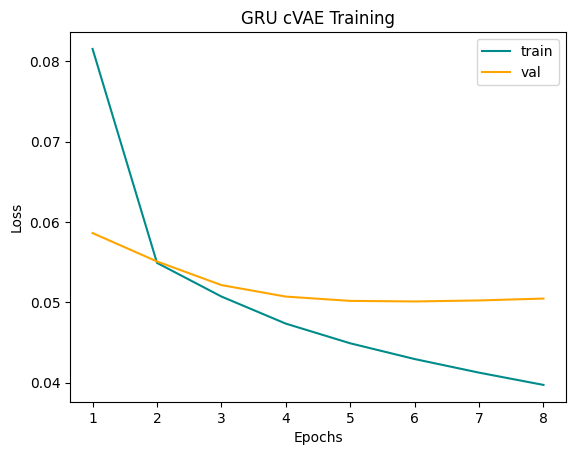

In [16]:
training(gru_cvae, train_loader, val_loader, 8, lr = 4e-4, title = 'GRU')

In [17]:
torch.save(gru_cvae.state_dict(), 'gru_cvae.pth')

# GRU VAE Inference

In [18]:
style_label = {'Dante' : torch.FloatTensor([1,0,0]), 'Italian' : torch.FloatTensor([0,1,0]), 'Neapolitan' : torch.FloatTensor([0,0,1])}
label = style_label['Dante']

gru_cvae.sample(label, 40, 0.6)

'e io vidi già nè sonno a me ne li occhi miei e io per me in quel suo foco ne l acqua si sentì col capo e li occhi con l altro del suo canto e poi che di'

# LSTM VAE Training

In [55]:
lstm_cvae = LSTMcVAE(embedding_matrix, idx2word, 3, hidden_dim, latent_dim, 2, sos_token, vocab_size)
lstm_cvae.number_parameters()

Total number of model parameters:  4088479


 12%|█▎        | 1/8 [05:11<36:17, 311.00s/it]

====> Epoch: 1 Average train loss: 0.0820, Average val loss: 0.0607


 25%|██▌       | 2/8 [10:23<31:12, 312.05s/it]

====> Epoch: 2 Average train loss: 0.0567, Average val loss: 0.0566


 38%|███▊      | 3/8 [15:40<26:10, 314.10s/it]

====> Epoch: 3 Average train loss: 0.0522, Average val loss: 0.0531


 50%|█████     | 4/8 [20:59<21:04, 316.13s/it]

====> Epoch: 4 Average train loss: 0.0484, Average val loss: 0.0511


 62%|██████▎   | 5/8 [26:24<15:57, 319.26s/it]

====> Epoch: 5 Average train loss: 0.0457, Average val loss: 0.0504


 75%|███████▌  | 6/8 [31:49<10:42, 321.13s/it]

====> Epoch: 6 Average train loss: 0.0436, Average val loss: 0.0501


 88%|████████▊ | 7/8 [37:14<05:22, 322.41s/it]

====> Epoch: 7 Average train loss: 0.0418, Average val loss: 0.0502


100%|██████████| 8/8 [42:39<00:00, 319.94s/it]

====> Epoch: 8 Average train loss: 0.0402, Average val loss: 0.0504


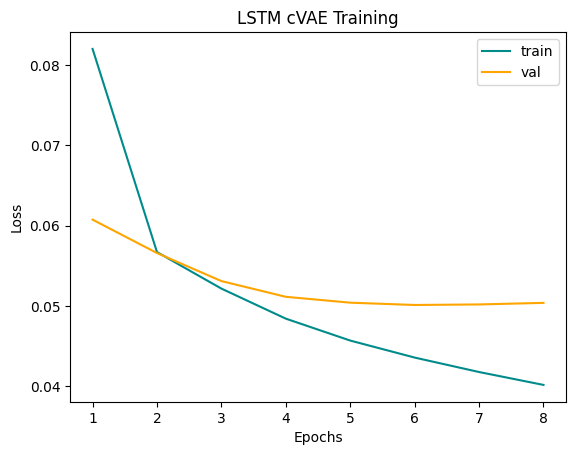

In [16]:
training(lstm_cvae, train_loader, val_loader, 8, lr = 4e-4, title = 'LSTM')

In [26]:
torch.save(lstm_cvae.state_dict(), 'lstm_cvae_cn.pth')

In [56]:
lstm_cvae.load_state_dict(torch.load('pretrained/lstm_cvae.pth'))

<ipython-input-56-0f6d58d4077f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lstm_cvae.load_state_dict(torch.load('pretrained/lstm_cvae.pth'))


<All keys matched successfully>

In [25]:
style_label = {'Dante' : torch.FloatTensor([1,0,0]), 'Italian' : torch.FloatTensor([0,1,0]), 'Neapolitan' : torch.FloatTensor([0,0,1])}
label = style_label['Dante']

lstm_cvae.sample(label, 40, 0.75)

'una orazion ma la fede che non se impressa chè l ciel in sua guida a miglior retroso sì che dietro a lui si move sostenea di sè fermo e per forza non di me mi disse per me m'

In [18]:
class CNNClassifier(nn.Module):
    def __init__(self, embedding_matrix, num_classes, num_filters, kernel_sizes):
        super(CNNClassifier, self).__init__()
        self.embedding_dim = embedding_matrix.shape[1]

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True)
        self.conv_layers = nn.ModuleList([nn.Conv2d(1, num_filters, (k, self.embedding_dim)) for k in kernel_sizes])
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)
        
    def forward(self,x):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        conv_results = [F.relu(conv(x)).squeeze(3) for conv in self.conv_layers]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conv_results]
        cat = torch.cat(pooled, dim = 1)
        out = self.fc(cat)
        return F.softmax(out, dim=-1)

In [19]:
def CNN_loss(y_s, labels, loss_fn=nn.CrossEntropyLoss()):
    L_mul_s = loss_fn(y_s, labels)

    return L_mul_s

In [20]:
def train_CNN(style_classif, train_loader, val_loader, num_epochs, lr = 4e-4):
    params = list(style_classif.parameters())

    optimizer = torch.optim.Adam(params, lr = lr)

    average_losses = []
    val_losses = []
    
    for epoch in tqdm(range(num_epochs)):
        train_loss = 0.0
        average_loss = 0.0
        val_loss = 0.0
        average_val_loss = 0.0
        
       
        for  i, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = labels.type(torch.FloatTensor)

            optimizer.zero_grad()


            pred_style = style_classif(data)
            
    
            loss_tot = CNN_loss(pred_style, labels)
            loss_tot.backward()
            train_loss += loss_tot.item()


            optimizer.step()
            
        
        
        average_loss = train_loss / len(train_loader.dataset)
        
        print(f'====> Epoch: {epoch+1} Average loss: {average_loss:.4f}')
        average_losses.append(average_loss)

        with torch.no_grad():
            for i, (data, labels) in enumerate(val_loader):
                data = data.to(device)
                labels = labels.type(torch.FloatTensor)
                

                pred_style = style_classif(data)

                
                
                val_loss_tot = CNN_loss(pred_style, labels)
                val_loss += val_loss_tot.item()


                
            
            
        average_val_loss = val_loss / len(val_loader.dataset)
        #print(f'====> Epoch: {epoch+1} Average loss: {average_val_loss:.4f}')
        val_losses.append(average_val_loss)

    
    plt.plot(np.linspace(1,num_epochs,len(average_losses)), average_losses, c = 'darkcyan',label = 'train')
    plt.plot(np.linspace(1,num_epochs,len(val_losses)), val_losses, c = 'orange',label = 'val')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()
    return average_losses

In [22]:
CNN_classif = CNNClassifier(embedding_matrix, 3, 2, [3,3])

In [23]:
style_params = sum(p.numel() for p in CNN_classif.parameters() if p.requires_grad)
print('Total parameters: ', style_params)

Total parameters:  3619


 25%|██▌       | 1/4 [00:04<00:12,  4.23s/it]

====> Epoch: 1 Average loss: 0.0049


 50%|█████     | 2/4 [00:08<00:08,  4.10s/it]

====> Epoch: 2 Average loss: 0.0044


 75%|███████▌  | 3/4 [00:13<00:04,  4.42s/it]

====> Epoch: 3 Average loss: 0.0044


100%|██████████| 4/4 [00:17<00:00,  4.25s/it]

====> Epoch: 4 Average loss: 0.0043


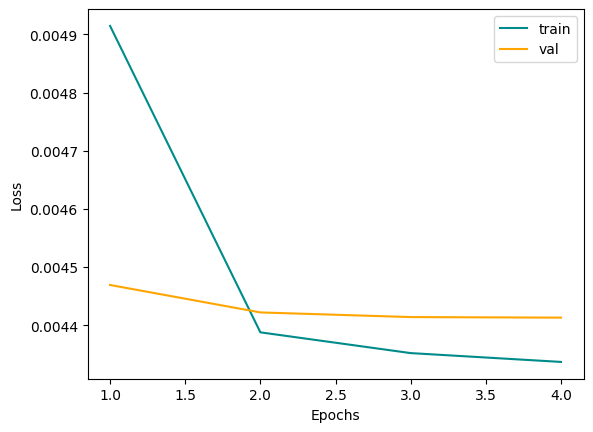

In [24]:
CNN_losses = train_CNN(CNN_classif,
                   train_loader,
                   val_loader,
                   num_epochs = 4,
                   lr = 1e-3)

In [25]:
wrong = 0.0
wrongy = []
with torch.no_grad():
    for i, (data, labels) in enumerate(val_loader):
        pred_style = torch.argmax(CNN_classif(data), dim=-1)
        label = torch.argmax(labels,dim=-1)
        wrong += torch.count_nonzero(label - pred_style)
        
print('Accuracy :', 1 - (wrong/(len(val_loader)*batch_size)).item(), '%')

Accuracy : 0.9951171875 %


In [65]:
def style_accuracy(cvae, classifier, n_samples = 1000, seq_length = 30, temperature = 0.7, name = 'RNN'):

    style_label = {'Dante' : torch.FloatTensor([1,0,0]), 'Italian' : torch.FloatTensor([0,1,0]), 'Neapolitan' : torch.FloatTensor([0,0,1])}


    label = style_label['Dante']

    dante_accuracy = 0.0

    for _ in tqdm(range(n_samples)):
        sentence = cvae.sample(label, seq_length, temperature)
        sentence = [word2idx[w] for w in sentence.split()]
        pred_label = torch.argmax(classifier(torch.tensor(sentence).unsqueeze(0)))
        if pred_label == 0.0:
            dante_accuracy += 1

    dante_accuracy = dante_accuracy / n_samples


    label = style_label['Italian']

    italian_accuracy = 0.0

    for _ in tqdm(range(n_samples)):
        sentence = cvae.sample(label, seq_length, temperature)
        sentence = [word2idx[w] for w in sentence.split()]
        pred_label = torch.argmax(classifier(torch.tensor(sentence).unsqueeze(0)))
        if pred_label == 1.0:
            italian_accuracy += 1

    italian_accuracy = italian_accuracy / n_samples



    label = style_label['Neapolitan']

    neapolitan_accuracy = 0.0

    for _ in tqdm(range(n_samples)):
        sentence = cvae.sample(label, seq_length, temperature)
        sentence = [word2idx[w] for w in sentence.split()]
        pred_label = torch.argmax(classifier(torch.tensor(sentence).unsqueeze(0)))
        if pred_label == 2.0:
            neapolitan_accuracy += 1

    neapolitan_accuracy = neapolitan_accuracy / n_samples


    overall_accuracy = (dante_accuracy + italian_accuracy + neapolitan_accuracy) / 3


    print(name, 'cVAE \n')

    print('Dante accuracy: ', dante_accuracy, '\n')

    print('Italian accuracy: ', italian_accuracy, '\n')
    
    print('Neapolitan accuracy: ', neapolitan_accuracy, '\n')

    print('Overall ', name, ' accuracy: ', overall_accuracy )

In [66]:
style_accuracy(lstm_cvae, CNN_classif, name = 'LSTM')

100%|██████████| 1000/1000 [01:45<00:00,  9.52it/s]

LSTM cVAE 

Dante accuracy:  0.967 

Italian accuracy:  0.974 

Neapolitan accuracy:  0.996 

Overall  LSTM  accuracy:  0.979


In [67]:
print('RNN cVae overall_accuracy: 98.30%, 99.10%, 100%, 99.13%')
print('GRU cVae accuracies: 93.50%, 93.80%, 99.60%, 95.63%')
print('LSTM cVae accuracies: 96.70%, 97.40%, 99.60%, 97.90%')

RNN cVae overall_accuracy: 98.30%, 99.10%, 100%, 99.13%
GRU cVae accuracies: 93.50%, 93.80%, 99.60%, 95.63%
LSTM cVae accuracies: 96.70%, 97.40%, 99.60%, 97.90%
